In [1]:
import os
import dlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from random import randint
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.ticker import FuncFormatter



In [2]:

# Rutas a los modelos y datos
model_paths = {
    'predictor_path': "../modelos/shape_predictor_68_face_landmarks.dat",
    'face_rec_model_path': "../modelos/dlib_face_recognition_resnet_model_v1.dat",
}
base_path = '../imagenes/base_15k/'


In [3]:

# Cargar modelos de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_paths['predictor_path'])
face_rec_model = dlib.face_recognition_model_v1(model_paths['face_rec_model_path'])


In [4]:
def load_and_encode(image_path):
    img = dlib.load_rgb_image(image_path)
    dets = detector(img, 1)
    if len(dets) > 0:
        shape = predictor(img, dets[0])
        face_descriptor = face_rec_model.compute_face_descriptor(img, shape)
        return np.array(face_descriptor)
    else:
        return None

def calculate_metrics(thresholds, cost_type_i, cost_type_ii, num_images):
    metrics = {t: {'FP': 0, 'FN': 0, 'TP': 0, 'TN': 0, 'Cost': 0, 'Labels': [], 'Predictions': []} for t in thresholds}

    for i in tqdm(range(num_images), desc="Processing images"):
        id_encoding = load_and_encode(f'{base_path}ID/ID_{i}.png')
        val_same_encoding = load_and_encode(f'{base_path}VAL/VAL_{i}.png')
        if id_encoding is None or val_same_encoding is None:
            continue
        
        non_matching_index = (i + randint(1, num_images - 1)) % num_images
        if non_matching_index == i:
            non_matching_index = (non_matching_index + 1) % num_images
        val_different_encoding = load_and_encode(f'{base_path}VAL/VAL_{non_matching_index}.png')
        if val_different_encoding is None:
            continue

        for threshold in thresholds:
            if np.linalg.norm(id_encoding - val_same_encoding) >= threshold:
                metrics[threshold]['FP'] += 1
                metrics[threshold]['Labels'].append(0)
                metrics[threshold]['Predictions'].append(1)
            else:
                metrics[threshold]['TN'] += 1
                metrics[threshold]['Labels'].append(0)
                metrics[threshold]['Predictions'].append(0)
            
            if np.linalg.norm(id_encoding - val_different_encoding) < threshold:
                metrics[threshold]['FN'] += 1
                metrics[threshold]['Labels'].append(1)
                metrics[threshold]['Predictions'].append(0)
            else:
                metrics[threshold]['TP'] += 1
                metrics[threshold]['Labels'].append(1)
                metrics[threshold]['Predictions'].append(1)

            metrics[threshold]['Cost'] = (metrics[threshold]['FP'] * cost_type_i) + (metrics[threshold]['FN'] * cost_type_ii)

    for threshold in thresholds:
        tp, tn, fp, fn = metrics[threshold]['TP'], metrics[threshold]['TN'], metrics[threshold]['FP'], metrics[threshold]['FN']
        total = tp + tn + fp + fn
        accuracy = (tp + tn) / total if total > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics[threshold].update({'Precision': precision, 'Recall': recall, 'F1': f1, 'Accuracy': accuracy})
    
    return metrics

In [5]:
# Parámetros configurables
num_images = 5000
thresholds = np.arange(0.2, 0.9, 0.01)
cost_type_i = 1100000*0.55
cost_type_ii = 250000

In [6]:
metrics = calculate_metrics(thresholds, cost_type_i, cost_type_ii, num_images)

Processing images: 100%|██████████| 5000/5000 [47:18<00:00,  1.76it/s]


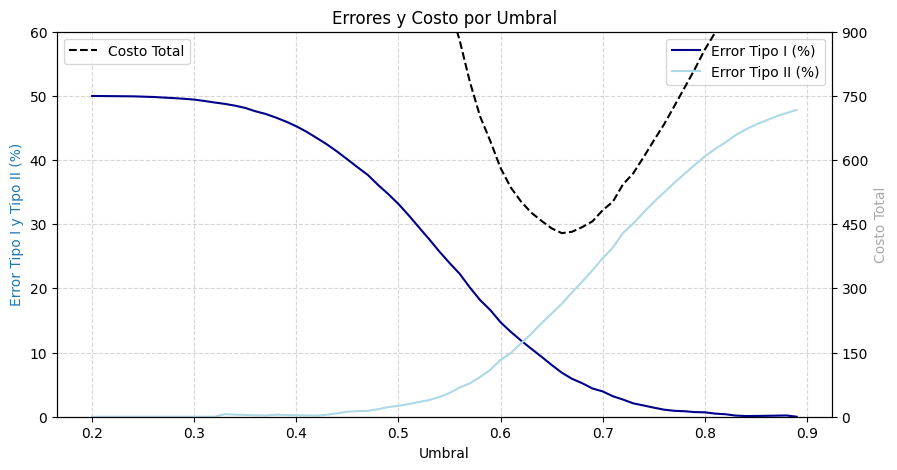

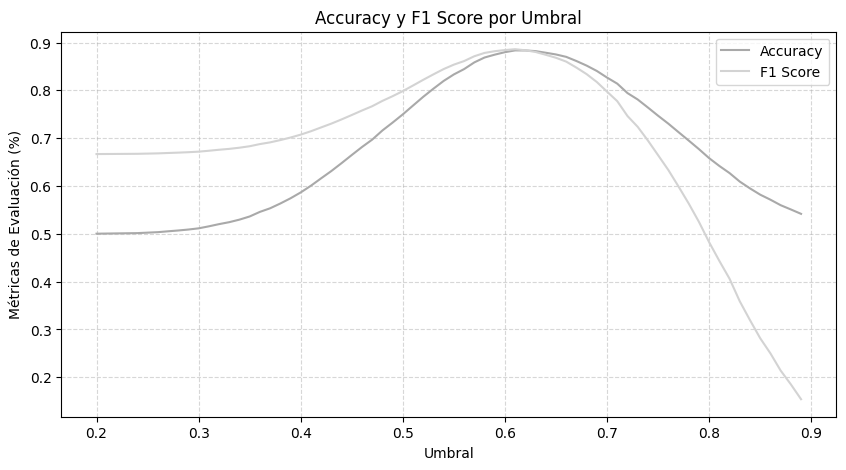

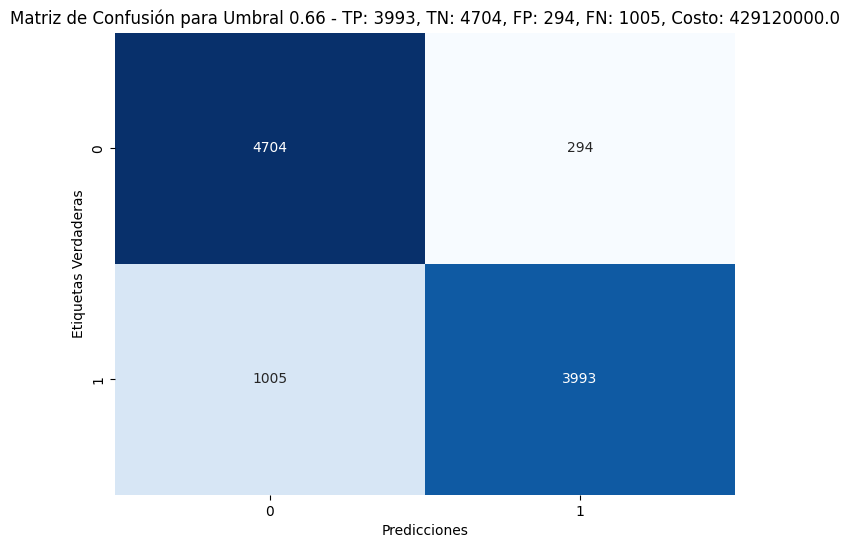

In [11]:
def int_formatter(x, pos):
    return f'{int(x/1e6)}'

# Errores y Costo por Umbral
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Umbral')
ax1.set_ylabel('Error Tipo I y Tipo II (%)', color='tab:blue')
ax1.plot(list(thresholds), [100 * metrics[t]['FP'] / (metrics[t]['FP'] + metrics[t]['TP']) if (metrics[t]['FP'] + metrics[t]['TP']) > 0 else 0 for t in thresholds], label='Error Tipo I (%)', color='darkblue')
ax1.plot(list(thresholds), [100 * metrics[t]['FN'] / (metrics[t]['FN'] + metrics[t]['TN']) if (metrics[t]['FN'] + metrics[t]['TN']) > 0 else 0 for t in thresholds], label='Error Tipo II (%)', color='lightblue')
ax1.set_ylim(bottom=0, top=60)
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Costo Total', color='darkgrey')
ax2.plot(list(thresholds), [metrics[t]['Cost'] for t in thresholds], label='Costo Total', color='black', linestyle='--')
ax2.set_ylim(bottom=0, top=9e8)
ax2.legend()

# Configurando grilla y ticks para que se alineen
ax1.grid(True, linestyle='--', which='both', axis='both', alpha=0.5)
ax1.set_yticks(np.linspace(0, 60, 7))  # 7 ticks en el eje primario
ax2.set_yticks(np.linspace(0, 9e8, 7))  # 7 ticks en el eje secundario para alinear con el primario
ax2.yaxis.set_major_formatter(FuncFormatter(int_formatter))

plt.title('Errores y Costo por Umbral')
plt.show()

# Accuracy y F1 Score por Umbral
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_xlabel('Umbral')
ax2.set_ylabel('Métricas de Evaluación (%)')
ax2.plot(list(thresholds), [metrics[t]['Accuracy'] for t in thresholds], label='Accuracy', color='darkgrey')
ax2.plot(list(thresholds), [metrics[t]['F1'] for t in thresholds], label='F1 Score', color='lightgrey')
ax2.legend()

plt.title('Accuracy y F1 Score por Umbral')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Matriz de Confusión para el umbral con el costo más bajo
min_cost_threshold = min(metrics, key=lambda x: metrics[x]['Cost'])
conf_mat = confusion_matrix(metrics[min_cost_threshold]['Labels'], metrics[min_cost_threshold]['Predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión para Umbral {round(min_cost_threshold,2)} - TP: {metrics[min_cost_threshold]["TP"]}, TN: {metrics[min_cost_threshold]["TN"]}, FP: {metrics[min_cost_threshold]["FP"]}, FN: {metrics[min_cost_threshold]["FN"]}, Costo: {metrics[min_cost_threshold]["Cost"]}')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()